In [1]:
import numpy as np
import pandas as pd
import mne
from mne_bids import BIDSPath, read_raw_bids
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# for mne, set the global log level to 'WARNING' or higher to suppress informational messages:
mne.set_log_level('WARNING')

In [3]:
# path to the BIDS dataset
bids_root = "/Users/amralaa/Desktop/Research Files/eeg_roman/TD_BRAIN_SAMPLE"

In [4]:
participants = pd.read_csv(bids_root + '/participants.tsv', sep = '\t')

We have EEG data for 20 subjects. Each subject has EEG data files for 2 conditions: eyes open (EO) and eyes closed (EC). Each csv file has ~ 60000 rows x 33 columns. Columns have letters and numbers (Fp1, Fp2, F7, F3, Fz, F4) representing standard labels for specific positions on the scalp according to the 10-20 system used in EEG measurements. 

To apply the attractor reconstruction method, we need a single feature vector for each subject and condition (we could possibly also combine conditions). To get that feature vector, we can try a couple of approaches initially:
1. Using summary statistics like maximum, minimum, mean, and standard deviation to combine data from channels: we extract basic statistical features from each channel's data, such as maximum, minimum, mean, and standard deviation. Now each subject will have 2 rows, one for each condition. Each row will represent summary stats for all cortical areas recorded.
2. Averaging all channel data. This method is known as "average referencing" or "common average reference" (CAR) in EEG analysis. Now for each subject conditoion, we get a single time series that captures the overall activity across all channels

In [5]:
# # using summary statistics

# def extract_features(data):
#     features = {
#         'max': np.max(data),
#         'min': np.min(data),
#         'mean': np.mean(data),
#         'std': np.std(data),
#         # Add more features as needed
#     }
#     return features

# def load_eeg_data(bids_root, participants, conditions):
#     data = []

#     for _, participant in participants.iterrows():
#         subject_id = participant['participant_id'].replace('sub-', '')  # Ensure the 'sub-' prefix is removed

#         for condition in conditions:
#             bids_path = BIDSPath(subject=subject_id, session='1', task=condition, datatype='eeg',
#                                  suffix='eeg', root=bids_root)
#             raw = read_raw_bids(bids_path)
#             raw.load_data()
#             # Remove bad channels
#             bad_channels = ['Fz']  # Specify the bad channels to remove
#             raw.info['bads'] = bad_channels
#             raw.pick_types(eeg=True, exclude='bads')

#             # Extract features for each channel
#             channel_features = {}
#             for channel in raw.ch_names:
#                 channel_data = raw.get_data(picks=channel).flatten()
#                 features = extract_features(channel_data)
#                 channel_features.update({f"{channel}_{key}": value for key, value in features.items()})

#             # Combine the features with subject_id and condition
#             combined_features = {
#                 'subject_id': subject_id,
#                 'condition': condition,
#                 **channel_features
#             }

#             data.append(combined_features)

#     combined_data = pd.DataFrame(data)

#     return combined_data

# conditions = ['restEC', 'restEO']  # Eyes closed and eyes open conditions
# eeg_data = load_eeg_data(bids_root, participants, conditions)
# eeg_data.head()

In [6]:
# averaging all channels

def load_eeg_data(bids_root, participants, conditions):
    data = []

    for _, participant in participants.iterrows():
        subject_id = participant['participant_id'].replace('sub-', '')  # Ensure the 'sub-' prefix is removed

        for condition in conditions:
            bids_path = BIDSPath(subject=subject_id, session='1', task=condition, datatype='eeg',
                                 suffix='eeg', root=bids_root)
            raw = read_raw_bids(bids_path)
            raw.load_data()
            # Remove bad channels
            bad_channels = ['Fz']  # Specify the bad channels to remove
            raw.info['bads'] = bad_channels
            raw.pick_types(eeg=True, exclude='bads')

            # Average data from all channels
            averaged_data = np.mean(raw.get_data(), axis=0)

            # Create a dictionary with subject_id, condition, and the averaged data
            subject_data = {
                'subject_id': subject_id,
                'condition': condition,
                'data': averaged_data
            }

            data.append(subject_data)

    combined_data = pd.DataFrame(data)

    return combined_data

conditions = ['restEC', 'restEO']  # Eyes closed and eyes open conditions
eeg_data = load_eeg_data(bids_root, participants, conditions)

In [7]:
eeg_data.iloc[0].data.shape

(60323,)

In [8]:
eeg_data.head()

,subject_id,condition,data
0,87965393,restEC,"[0.00047711157836914143, 0.0004763822509765626..."
1,87965393,restEO,"[0.00016473036499023333, 0.0001661067199707032..."
2,87966293,restEC,"[-0.005658755189514159, -0.005660535525512695,..."
3,87966293,restEO,"[-0.005753424639892578, -0.00575326775970459, ..."
4,87966293,restEC,"[-0.005658755189514159, -0.005660535525512695,..."


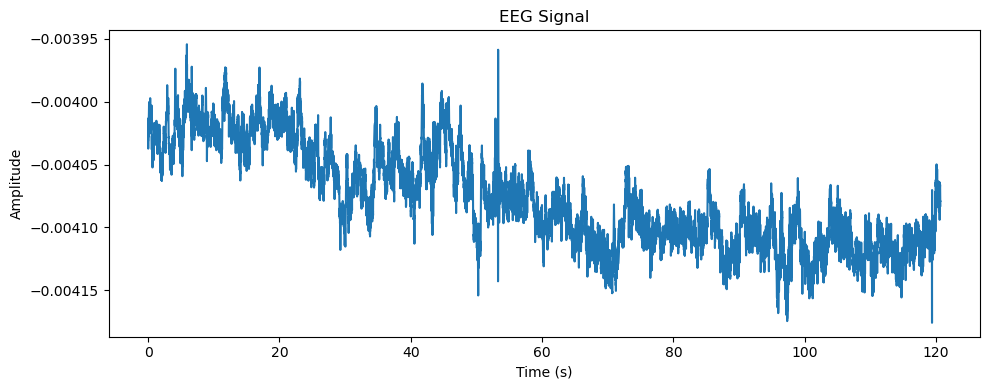

In [9]:
def plot_eeg_signal(eeg_signal):
    sampling_rate = 500
    time = np.arange(len(eeg_signal)) / sampling_rate
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(time, eeg_signal);
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title('EEG Signal')
    
    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

plot_eeg_signal(eeg_signal = eeg_data.iloc[10].data)

2- Reconstruct the attractor using delay coordinates

- Choose an embedding dimension (n) and time delay (τ).
- For each time window, create the delay coordinates x(t), y(t), and z(t) as described in the method.


In [10]:
from scipy.signal import find_peaks

n = 3
sampling_frequency = 500

def compute_tau(signal):
    peaks, _ = find_peaks(signal)
    cycle_lengths = np.diff(peaks)  # Calculate the differences between consecutive peak indices
    avg_cycle_length = np.mean(cycle_lengths) / sampling_frequency * 1000 # Convert to milliseconds
    tau = int(avg_cycle_length // 3)
    return tau
    
def reconstruct_attractor(signal, n, tau):
    x = signal[:-2*tau]
    y = signal[tau:-tau]
    z = signal[2*tau:]
    return np.column_stack((x, y, z))


attractors = {}

for idx, row in eeg_data.iterrows():
    signal = row['data']
    tau = compute_tau(signal)
    attractor = reconstruct_attractor(signal, n, tau)
    attractors[(row['subject_id'], row['condition'])] = attractor

3 - Remove baseline variation

- Project the reconstructed attractor onto a plane perpendicular to the vector (1, 1, 1) using the equations for u, v, and w.

In [11]:
def remove_baseline_variation(attractor):
    '''Removes baseline variation by projecting attractor in (v, w) space'''
    x, y, z = attractor[:, 0], attractor[:, 1], attractor[:, 2]
    u = (x + y + z) / np.sqrt(3)
    v = (x + y - 2*z) / np.sqrt(6)
    w = (x - y) / np.sqrt(2)
    return np.column_stack((v, w))

projected_attractors = {}
for key, attractor in attractors.items():
    projected_attractor = remove_baseline_variation(attractor)
    projected_attractors[key] = projected_attractor

Plot Phase planes for all subjects:

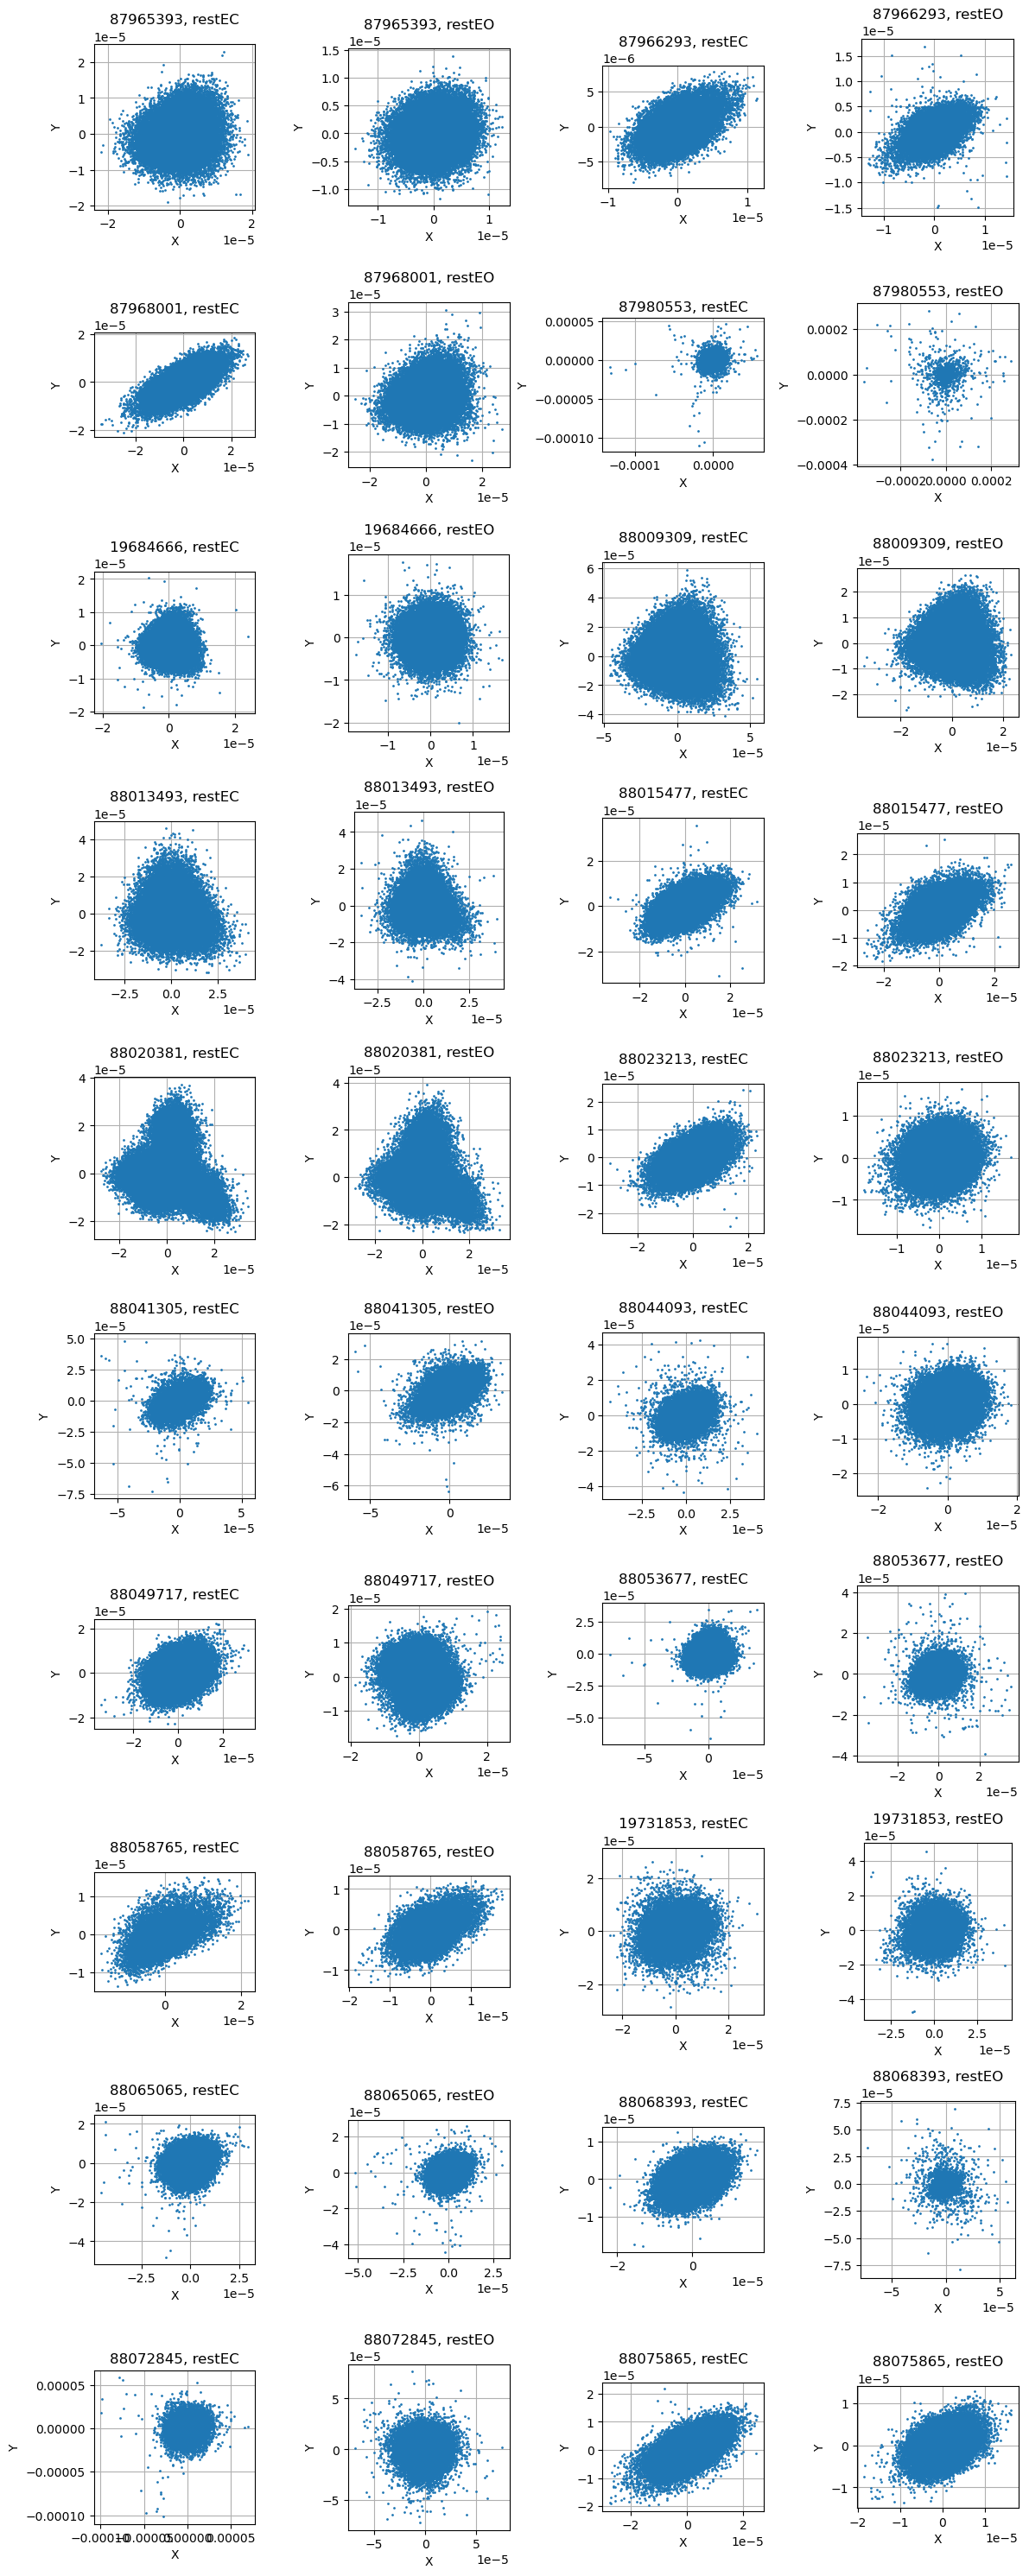

In [12]:
def plot_phase_plane(subject, condition, vectors, ax):
    x = vectors[:, 0]
    y = vectors[:, 1]
    
    ax.plot(x, y, 'o', markersize=1)
    
    # ax.set_title(f"Subject: {subject}, Condition: {condition}")
    ax.set_title(f"{subject}, {condition}")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    
    ax.grid(True)
    ax.set_aspect('equal')

num_entries = len(projected_attractors)
num_cols = 4
num_rows = (num_entries + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 3 * num_rows))
axes = axes.flatten() # Flatten the axes array for easier indexing

for i, (key, vectors) in enumerate(projected_attractors.items()):
    subject, condition = key
    ax = axes[i]
    plot_phase_plane(subject, condition, vectors, ax)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# plt.savefig("phase_planes.png")
plt.show()

plt.close(fig)